# PhishBuster - Spam Classification

## Business Understanding

### Background:
Email communication is a critical component of both personal and professional life, but it is also a common vector for cyberattacks. Unsafe emails, such as phishing attempts, spam, or emails containing malicious links or attachments, pose significant risks to users and organizations. Detecting and classifying emails as either safe or unsafe is crucial for protecting sensitive information, preventing financial loss, and ensuring overall cybersecurity.

### Problem Statement:
The problem is to develop a robust system that can automatically classify incoming emails into two categories: safe and unsafe. Safe emails are legitimate and pose no security threat, while unsafe emails include phishing attempts, spam, and those containing potentially harmful content such as malware or links to malicious websites.

### Objectives
- **Accurate Classification:** Maximize the precision and recall in detecting unsafe emails while minimizing false positives and false negatives.
- **Timely Detection:** Ensure the system processes emails efficiently, providing near-real-time classification.
- **Scalability:** The solution should handle large volumes of emails commonly encountered in corporate or enterprise environments.
- **Explainability:** The system should offer insights into why an email was classified as safe or unsafe to help users and administrators make informed decisions.
- **Adaptability:** The system should evolve and adapt to new and emerging threats in the email domain.

### Impact:
- **Enhanced Security:** An ML-driven system can provide more accurate detection of unsafe emails, reducing the likelihood of security breaches caused by phishing or malware.
- **Operational Efficiency:** Automating email classification saves time and resources for IT and security teams, allowing them to focus on higher-priority tasks.
- **Reduced Financial Losses:** Proactively identifying and stopping unsafe emails prevents costly cyber incidents, including ransomware attacks and data theft.
- **Improved User Experience:** Fewer false positives mean legitimate emails are not unnecessarily blocked, ensuring smoother communication for end users.
- **Regulatory Compliance:** Effective email filtering helps organizations comply with cybersecurity and data protection regulations (e.g., GDPR, HIPAA) by preventing unauthorized access to sensitive information.
- **Competitive Advantage:** Offering or leveraging state-of-the-art ML email protection can position a company as a leader in cybersecurity, building trust with clients and stakeholders.

---

## Importing Required Libraries
Before we begin, we will import all required libraries. They are grouped by the stage they are first used.


In [1]:
# Import required libraries

# Data Collection and Understanding
import pandas as pd  # For data manipulation and analysis, such as reading datasets and creating dataframes.
import mailbox  # To parse and extract data from mailbox files (.mbox).
from bs4 import BeautifulSoup  # For parsing and extracting content from HTML emails.
import matplotlib.pyplot as plt  # For creating static, interactive, and publication-quality visualizations.
import seaborn as sns  # For creating advanced and aesthetically pleasing visualizations.
import numpy as np  # For numerical computations and operations, including array manipulations and statistical calculations.

# Natural Language Processing
import nltk  # A suite of libraries and programs for natural language processing (NLP).
from nltk.corpus import stopwords  # To remove common words (e.g., 'and', 'the') that do not add significant meaning.
from textblob import TextBlob  # For performing sentiment analysis and other NLP tasks.
from nltk.stem import WordNetLemmatizer  # For reducing words to their base or root form.
from sklearn.feature_extraction.text import TfidfVectorizer  # For converting text data into numerical feature vectors.
from wordcloud import WordCloud  # To generate word cloud visualizations for text analysis.

# Data Splitting
from sklearn.model_selection import train_test_split  # To split the dataset into training and testing sets.

# Model Building
from sklearn.naive_bayes import MultinomialNB  # A Naive Bayes classifier for text data, particularly for spam detection.
from sklearn.svm import SVC  # Support Vector Classifier for building classification models.
from sklearn.ensemble import GradientBoostingClassifier  # An ensemble learning model for classification tasks.

# Model Evaluation and Tuning
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report  # For evaluating model performance.
from sklearn.model_selection import GridSearchCV  # To perform hyperparameter tuning for models.
from sklearn.metrics import confusion_matrix  # For analyzing classification results with a confusion matrix.

# Model Export
import pickle  # To save and load trained models for later use.


## Data Collection and Understanding

For our training data, we used a collection of public databases containing labeled text data of safe and dangerous email messages.

This consisted of:
1. [Phishing_Email.csv](https://www.kaggle.com/datasets/subhajournal/phishingemails/data)
2. [spam.csv](https://www.kaggle.com/datasets/muhammedtariq99/phishing-detection)
3. [phishing_data_by_type.csv](https://www.kaggle.com/datasets/charlottehall/phishing-email-data-by-type)
4. [emails-phishing.mbox](https://github.com/diegoocampoh/MachineLearningPhishing)

To integrate our data, we compiled the datasets into a single *CSV* file with two columns:
1. **text**: The text of the email.
2. **type**: The type of email (safe/unsafe).

The *emails-phishing.mbox* dataset demanded additional consideration. Instead of partially processed structured data, it contained a raw collection of genuine phishing emails with everything intact. To integrate it into our data pipeline, we used the Python *mailbox* library to transform the emails into our desired format.


### Steps:
1. First, we will deal with the three *CSV* datasets. 
   - Read them into dataframes.
   - Retain the features required for analysis.
   - Rename the features to maintain consistency across all datasets.

In [2]:
# Phishing_Email.csv
# Read the CSV file into a DataFrame
df1 = pd.read_csv("./data/Phishing_Email.csv")
# Select only the features of interest: 'Email Text' and 'Email Type'
df1 = df1[['Email Text', 'Email Type']]
# Rename the columns to maintain consistency across datasets
df1 = df1.rename(columns={'Email Text': 'text', 'Email Type': 'type'})

# spam.csv
# Read the CSV file into a DataFrame with the correct encoding
df2 = pd.read_csv('./data/spam.csv', encoding='latin-1')
# Select only the features of interest: 'v1' (type) and 'v2' (text)
df2 = df2[['v1', 'v2']]
# Rename the columns to maintain consistency across datasets
df2 = df2.rename(columns={'v1': 'type', 'v2': 'text'})

# phishing_data_by_type.csv
# Read the CSV file into a DataFrame
df3 = pd.read_csv('./data/phishing_data_by_type.csv')
# Select only the features of interest: 'Type' and 'Text'
df3 = df3[['Type', 'Text']]
# Rename the columns to maintain consistency across datasets
df3 = df3.rename(columns={'Type': 'type', 'Text': 'text'})


### Standardizing the Datasets

To standardize the datasets, we need to replace the text categories with numerical values. This ensures consistency and simplifies the classification process for machine learning algorithms.


In [3]:
# Standardize the 'type' column by replacing text categories with numerical values.

# For Phishing_Email.csv
# Replace 'Safe Email' with 0 (safe) and 'Phishing Email' with 1 (unsafe)
df1['type'] = df1['type'].replace({'Safe Email': 0, 'Phishing Email': 1})

# For spam.csv
# Replace 'ham' with 0 (safe) and 'spam' with 1 (unsafe)
df2['type'] = df2['type'].replace({'ham': 0, 'spam': 1})

# For phishing_data_by_type.csv
# Replace different categories of unsafe emails ('Phishing', 'Fraud', 'Commercial Spam') with 1 (unsafe)
# Replace 'False Positives ' with 0 (safe)
df3['type'] = df3['type'].replace({
    'False Positives ': 0,  # Safe emails
    'Phishing': 1,         # Unsafe emails
    'Fraud': 1,            # Unsafe emails
    'Commercial Spam': 1   # Unsafe emails
})


C:\Users\loewe\AppData\Local\Temp\ipykernel_15284\357088770.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['type'] = df1['type'].replace({'Safe Email': 0, 'Phishing Email': 1})
C:\Users\loewe\AppData\Local\Temp\ipykernel_15284\357088770.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['type'] = df2['type'].replace({'ham': 0, 'spam': 1})
C:\Users\loewe\AppData\Local\Temp\ipykernel_15284\357088770.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain 

### Handling the mbox Dataset

Next, we will process the *mbox* dataset. Since this file contains genuine phishing emails, it may be quarantined by antivirus software. To safely handle this dataset, we used a secure environment to extract the necessary features. 

After processing, the integrated DataFrame was saved as a CSV file for future access, ensuring safe and convenient usage without requiring repeated extraction from the raw *mbox* file.


In [4]:
# Process emails-phishing.mbox dataset

# This loop iterates through individual messages in the mbox file
d = []
for message in mailbox.mbox('./data/emails-phishing.mbox'):
    # Get the payload (body text) of the email, decoding it if necessary
    payload = message.get_payload(decode=True)
    
    # Check if the payload is empty
    if payload is None:
        cleantext = ""  # Assign an empty string for empty payloads
    else:
        # Use BeautifulSoup to parse the email's HTML content into plain text
        cleantext = BeautifulSoup(payload, "html.parser").text
        
        # Remove unnecessary newline and tab characters for cleaner text
        cleantext = cleantext.replace("\n", " ")
        cleantext = cleantext.replace("\t", " ")
    
    # Append the cleaned email content as a dictionary to the list
    d.append({'text': cleantext})

# Create a DataFrame from the list of dictionaries
df4 = pd.DataFrame(d)

# Add a 'type' column with a fixed value of 1 (indicating these are all unsafe emails)
df4['type'] = 1


### Combining Datasets

Finally, we can combine the four DataFrames into a single unified dataset. This consolidated dataset will then be saved as a CSV file for future access, ensuring all preprocessed data is readily available for analysis and modeling.


In [5]:
# Combine all preprocessed DataFrames into one unified dataset
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

# Explanation:
# - pd.concat() is used to concatenate the four DataFrames (df1, df2, df3, df4).
# - The 'ignore_index=True' parameter resets the index for the combined dataset, 
#   ensuring a continuous index from 0 to the total number of rows.

# Optional: Save the combined dataset to a CSV file for future use
# Uncomment the following line if you wish to save the file:
df.to_csv("data/integrated_data.csv")

# Note:
# Saving the dataset allows you to avoid repeating the preprocessing steps 
# and directly load the cleaned data in subsequent analysis or modeling phases.


### Exploratory Data Analysis (EDA)

With our dataset integrated, we can perform some basic data analysis. Since this is a simple dataset with only two features (`text` and `type`), there isn't much to explore at this stage. However, after applying NLP techniques in the feature engineering stage, we will revisit and perform more detailed analysis.

For now, let's load the dataset and take a look at its structure.


In [6]:
# Load the dataset if it has been saved previously
# Uncomment the following line if loading from a CSV file is needed
df = pd.read_csv('./data/integrated_data.csv')

# Display the dataset
# The pd.option_context() function temporarily sets display options for the DataFrame.
# In this case, 'display.max_rows' is set to None, allowing all rows of the DataFrame to be printed.
with pd.option_context('display.max_rows', None):
    print(df)

# Explanation:
# - If the dataset was saved in the preprocessing stage, the CSV file can be loaded into a DataFrame.
# - The `pd.option_context()` ensures that all rows of the DataFrame are displayed in the console, 
#   overriding the default limit on the number of rows shown. This is particularly useful for inspecting 
#   smaller datasets without truncation.
# - This code is useful for verifying the contents and structure of the DataFrame before proceeding to analysis or modeling.


       Unnamed: 0                                               text  type
0               0  re : 6 . 1100 , disc : uniformitarianism , re ...     0
1               1  the other side of * galicismos * * galicismo *...     0
2               2  re : equistar deal tickets are you still avail...     0
3               3  \nHello I am your hot lil horny toy.\n    I am...     1
4               4  software at incredibly low prices ( 86 % lower...     1
5               5  global risk management operations sally congra...     0
6               6  On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...     0
7               7  entourage , stockmogul newsletter ralph velez ...     1
8               8  we owe you lots of money dear applicant , afte...     1
9               9  re : coastal deal - with exxon participation u...     0
10             10  make her beg you to give it to her everynight ...     1
11             11  URL: http://www.newsisfree.com/click/-5,830431...     0
12             12  begin 

In [7]:
# Print the content of the 'text' column for the 4th row in the DataFrame
print(df.text[3])

# Explanation:
# - `df.text[3]` accesses the value in the 'text' column of the DataFrame at index 3.
# - Python uses zero-based indexing, so index 3 corresponds to the 4th row in the DataFrame.
# - This command allows you to inspect the email text content for a specific row, 
#   which is useful for understanding the dataset and verifying the preprocessing results.



Hello I am your hot lil horny toy.
    I am the one you dream About,
    I am a very open minded person,
    Love to talk about and any subject.
    Fantasy is my way of life, 
    Ultimate in sex play.     Ummmmmmmmmmmmmm
     I am Wet and ready for you.     It is not your looks but your imagination that matters most,
     With My sexy voice I can make your dream come true...
  
     Hurry Up! call me let me Cummmmm for you..........................
TOLL-FREE:             1-877-451-TEEN (1-877-451-8336)For phone billing:     1-900-993-2582
-- 
_______________________________________________
Sign-up for your own FREE Personalized E-mail at Mail.com
http://www.mail.com/?sr=signup


In [8]:
# Viewing the shape of the DataFrame
df.shape

# Explanation:
# - The `shape` attribute of a DataFrame returns a tuple representing the dimensionality of the DataFrame.
# - The first value (24381) indicates the number of rows, which corresponds to the total number of emails in the dataset.
# - The second value (2) indicates the number of columns, which corresponds to the two features: 'text' (email content) and 'type' (email category).

# Output:
# (24381, 2)
# This means the dataset contains 24,381 emails and 2 features.


(24381, 3)

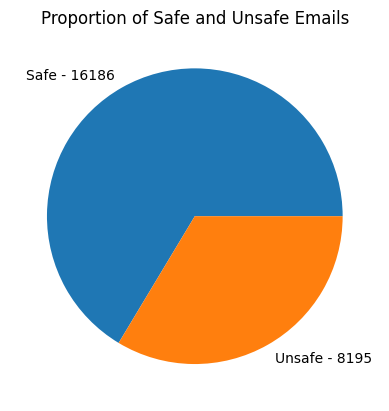

In [9]:
# Viewing the proportion of safe and unsafe emails in the dataset.
# Observing class distribution helps identify any imbalance, which may affect model performance.
# The dataset has a noticeable imbalance: 16,186 safe emails and 8,195 unsafe emails.

# Count the number of safe (0) and unsafe (1) emails
count = [int(df.type.value_counts()[0]), int(df.type.value_counts()[1])]

# Create labels for the pie chart, including the counts
labels = [f'Safe - {int(df.type.value_counts()[0])}', f'Unsafe - {int(df.type.value_counts()[1])}']

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(count, labels=labels)  # Plot the pie chart with counts and labels
ax.set_title("Proportion of Safe and Unsafe Emails")  # Add a title to the chart

# Display the pie chart
plt.show()

# Explanation:
# - `df.type.value_counts()` calculates the frequency of each unique value in the 'type' column.
# - The counts are converted to integers and stored in the `count` list for use in the pie chart.
# - `labels` is created to display the class name ('Safe' or 'Unsafe') along with its count.
# - `plt.pie()` generates a pie chart to visualize the class distribution.
# - The chart highlights the class imbalance in the dataset, which is important for understanding potential biases in model training.


### Variables

Our dataset is now ready to be prepared. We will perform feature engineering on the **text** feature (**the independent variable**) using natural language processing to make it suitable for input. The **type** feature (**our dependent variable**) is already prepared for use.


## Data Preparation

In this stage, we will:
1. Wrangle the data.
2. Engineer the features.
3. Perform exploratory data analysis (EDA) on the finalized features.
4. Split the data into training and validation sets.

### Wrangle Data

To begin, we will check for missing values. The dataset contains 1,088 missing values. These will be dropped to ensure the data is clean and ready for processing.

In [10]:
# Check for empty string values in the 'text' column
print(df.where(df['text'] == '').count())

# Explanation:
# - `df.where(df['text'] == '')` identifies rows where the 'text' column contains an empty string.
# - `.count()` counts the number of such occurrences for each column.
# - This step ensures we can quantify and locate missing or empty data in the dataset.

# Drop rows with empty strings in the 'text' column
df = df.drop(df[df['text'] == ''].index)

# Explanation:
# - `df['text'] == ''` creates a boolean mask identifying rows with empty strings.
# - `df.drop()` removes these rows using their indices (`.index`).

# Check again for empty string values to verify the cleanup
print(df.where(df['text'] == '').count())

# Explanation:
# - After removing rows with empty strings, the count should return 0 for all columns.
# - This ensures the dataset is free of empty string values in the 'text' column.


Unnamed: 0    0
text          0
type          0
dtype: int64
Unnamed: 0    0
text          0
type          0
dtype: int64


There isn't much more we can do at this stage. Let's move on to feature engineering.

### Feature Engineering

This is the meat and potatoes of natural language processing. The algorithm we will be using for modeling—**Naive Bayes**—requires our input feature to be vectorized. To achieve this, we need to preprocess the text data and transform it into a numerical representation.


#### Text Preprocessing

The raw text needs to be preprocessed to remove unnecessary information.

This involves:
- **Removing capitalization:** Ensures consistency by converting all text to lowercase.
- **Removing punctuation:** Eliminates characters that do not add meaning to the text.
- **Removing stopwords:** Removes common words (e.g., "and," "the") that do not carry significant information.
- **Standardizing the words with Lemmatization:** Reduces words to their base or dictionary form.

We will define a function to perform these steps and use it to add a new column to our DataFrame containing the preprocessed (cleaned) text. To remove stopwords, we will also download a predefined list of stopwords.

In [11]:
# Load the stopword list for text preprocessing
nltk.download('stopwords')  # Download the stopwords dataset from NLTK

# Create a list of English stopwords
stop_words = stopwords.words('english')

# Explanation:
# - The `nltk.download('stopwords')` command downloads a predefined list of stopwords provided by NLTK.
# - Stopwords are common words in a language (e.g., 'and', 'the', 'is') that do not carry significant meaning and are often removed in natural language processing tasks.
# - The `stopwords.words('english')` function retrieves the list of English stopwords.
# - This list will be used in the text preprocessing step to filter out irrelevant words, improving the quality of the input data for modeling.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\loewe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Define a text pre-processing function
# This function takes a string as input and returns the preprocessed version of the string.
def preprocess_text(text):
    # Construct a TextBlob object from the text for text manipulation
    blob = TextBlob(text)

    # Convert all words in the text to lowercase
    words = [word.lower() for word in blob.words]
    
    # Remove punctuation by keeping only alphabetic words
    words = [word for word in words if word.isalpha()]
    
    # Remove stopwords (common words that carry little meaning)
    words = [word for word in words if word not in stop_words]

    # Perform text normalization using lemmatization
    # Lemmatization reduces words to their base or root form (e.g., "running" -> "run")
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join the processed words back into a single string
    text = ' '.join(words)
    return text

# Explanation of Steps:
# 1. **Convert to lowercase:** Ensures consistency in text representation (e.g., "The" and "the" are treated the same).
# 2. **Remove punctuation:** Filters out non-alphabetic characters to focus on meaningful words.
# 3. **Remove stopwords:** Eliminates common words that do not add significant information (e.g., "is", "and").
# 4. **Lemmatization:** Reduces words to their root form, aiding in standardization (e.g., "studies" -> "study").
# 5. **Join words:** Combines the processed list of words into a single string for further use.

# Purpose:
# This function cleans and standardizes the input text, making it suitable for natural language processing tasks like vectorization and modeling.


With our preprocessing function set up, we can now apply it to the **text** feature in our DataFrame to clean and standardize the email content.


In [13]:
# Apply the preprocessing function to the text data
df['clean_text'] = df['text'].astype(str).apply(preprocess_text)

# Explanation:
# - `df['text'].astype(str)`: Ensures that the 'text' column is treated as a string, preventing errors during preprocessing if any non-string values exist.
# - `.apply(preprocess_text)`: Applies the `preprocess_text` function to each entry in the 'text' column.
# - The cleaned and preprocessed text is stored in a new column named 'clean_text', preserving the original text in the 'text' column.

# Purpose:
# - This step preprocesses the raw email content (stored in the 'text' column) and creates a standardized, cleaned version of the data.
# - The `clean_text` column will be used as input for feature extraction and modeling, ensuring the text is ready for vectorization.


#### Text Vectorizing

To accurately represent the cleaned text with numerical values, we can use **Term Frequency-Inverse Document Frequency (TFIDF)**. This technique creates a matrix of numbers where each value represents the importance of a word in a given text, based on its frequency in the document and its rarity across all documents.


In [14]:
# Initialize the TFIDF Vectorizer
tfidf = TfidfVectorizer()

# Fit and transform the cleaned text data with the TFIDF vectorizer
vectors = tfidf.fit_transform(df.clean_text)

# Print the shape of the resulting TFIDF matrix
print(f"Emails: {vectors.shape[0]}, Words: {vectors.shape[1]}")

# Explanation:
# 1. **Initialization**:
#    - `TfidfVectorizer()` initializes a vectorizer that converts text into numerical features using the Term Frequency-Inverse Document Frequency method.
#    - This method calculates the importance of a word based on its frequency in a document and its rarity across all documents.

# 2. **Fit and Transform**:
#    - `.fit_transform(df.clean_text)`:
#      - `fit` learns the vocabulary and calculates the TFIDF weights from the cleaned text in the 'clean_text' column.
#      - `transform` converts the cleaned text into a sparse matrix where rows represent emails and columns represent unique words.

# 3. **Shape of the TFIDF Matrix**:
#    - `vectors.shape[0]`: Represents the number of emails (24381 in this case).
#    - `vectors.shape[1]`: Represents the number of unique words across the dataset after preprocessing (122791 in this case).

# Purpose:
# - This step creates a numerical representation of the text data, which is essential for machine learning models.
# - The sparse matrix output allows efficient storage and computation, especially for large datasets with high-dimensional features.


Emails: 24381, Words: 122791


### Exploratory Data Analysis (EDA)

Now that our data is prepared, we can perform some additional analysis.

A useful way to understand the text data is by visualizing it with a **Word Cloud**. This allows us to see the most frequent words in the dataset. We will generate separate word clouds for **safe emails** and **unsafe emails** to compare the differences in their content.


In [15]:
# Define WordCloud objects for safe and unsafe emails
safe_wordcloud = WordCloud(
    background_color='white',  # Sets the background color to white for better visibility
    max_words=200,             # Limits the word cloud to display the top 200 most frequent words
    max_font_size=40,          # Sets the maximum font size for the largest words
    scale=3,                   # Adjusts the resolution of the word cloud
    random_state=1             # Ensures reproducibility by fixing the random state
)

unsafe_wordcloud = WordCloud(
    background_color='white',  # Same settings as above for unsafe emails
    max_words=200,
    max_font_size=40,
    scale=3,
    random_state=1
)

# Combine all the text from safe emails into a single string
safe_string = ''
for s in df[df['type'] == 0].clean_text:  # Filter rows where 'type' is 0 (safe emails)
    safe_string = safe_string + s         # Concatenate all 'clean_text' values into a single string

# Combine all the text from unsafe emails into a single string
unsafe_string = ''
for s in df[df['type'] == 1].clean_text:  # Filter rows where 'type' is 1 (unsafe emails)
    unsafe_string = unsafe_string + s     # Concatenate all 'clean_text' values into a single string

# Generate word clouds for safe and unsafe emails
safe_wordcloud.generate(safe_string)      # Generate a word cloud using the combined text from safe emails
unsafe_wordcloud.generate(unsafe_string)  # Generate a word cloud using the combined text from unsafe emails

# Explanation:
# - The `WordCloud` object is used to create visual representations of the most frequent words in the text.
# - Text from safe and unsafe emails is separately concatenated into single strings for input to the `generate()` method.
# - The `generate()` method analyzes the frequency of words in the provided text and creates a word cloud.
# - Separate word clouds allow comparison of common words in safe and unsafe emails, h


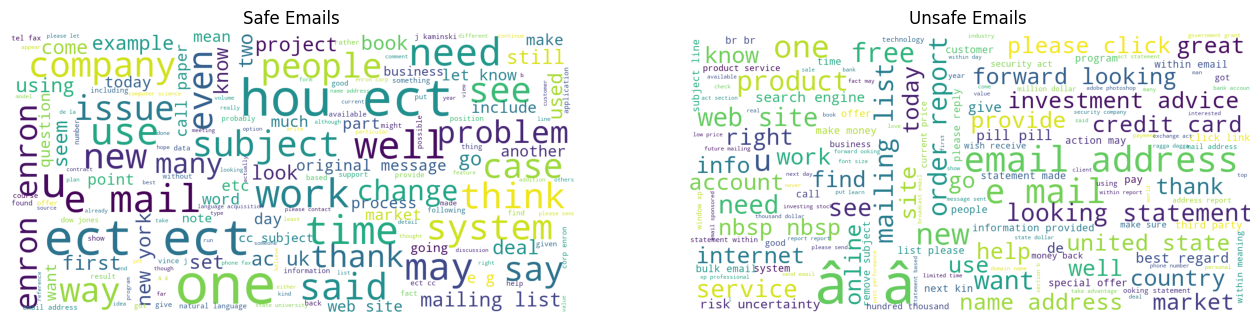

In [16]:
# Define the plot for visualizing the word clouds
fig = plt.figure(1, figsize=(16, 16))  # Create a figure with a specified size (16x16 inches)

# Add the word cloud for safe emails to the plot
ax = fig.add_subplot(1, 2, 1)  # Add a subplot in a 1x2 grid (first position)
ax.imshow(safe_wordcloud)      # Display the safe emails word cloud
ax.set_title('Safe Emails')    # Set the title for the subplot
ax.axis('off')                 # Turn off the axis to enhance visualization

# Add the word cloud for unsafe emails to the plot
ax = fig.add_subplot(1, 2, 2)  # Add a subplot in a 1x2 grid (second position)
ax.imshow(unsafe_wordcloud)    # Display the unsafe emails word cloud
ax.set_title('Unsafe Emails')  # Set the title for the subplot
ax.axis('off')                 # Turn off the axis for clean visualization

# Show the plot
plt.show()

# Explanation:
# - `plt.figure()` initializes the figure with a specified size.
# - `fig.add_subplot(1, 2, 1)` and `fig.add_subplot(1, 2, 2)` create subplots in a 1-row, 2-column layout.
# - `ax.imshow()` displays the respective word cloud images in each subplot.
# - `ax.set_title()` sets a title for each subplot to identify the type of email (safe or unsafe).
# - `ax.axis('off')` removes the axis lines and labels for a cleaner look.
# - `plt.show()` renders the final visualization, showing the word clouds side by side for comparison.

# Purpose:
# This visualization compares the most frequent words in safe and unsafe emails, making it easier to identify patterns or commonalities in the text for each category.


### Data Splitting

With our feature engineering and analysis complete, the final step in preparing the data is to split it into subsets for training and testing the model. 

We will reserve **80% of the data for training** the model and **20% for testing**, following standard practice. This ensures that the model is evaluated on unseen data to measure its performance effectively.


In [17]:
# Define the independent variables (X)
X = vectors  # The TFIDF vectorized representation of the cleaned email text

# Define the dependent variables (y)
y = df['type']  # The 'type' column indicating safe (0) or unsafe (1) emails

# Perform an 80:20 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,               # Independent variables (TFIDF matrix)
    y,               # Dependent variable (labels)
    test_size=0.2,   # 20% of the data is reserved for testing
    random_state=42  # Ensures reproducibility by fixing the random seed
)

# Explanation:
# - `X` contains the numerical representation of the text data (TFIDF matrix).
# - `y` contains the corresponding labels indicating whether each email is safe or unsafe.
# - `train_test_split()` splits the data into training and testing sets:
#   - 80% of the data (`X_train`, `y_train`) is used to train the model.
#   - 20% of the data (`X_test`, `y_test`) is held out for evaluating the model's performance.
# - The `random_state=42` parameter ensures that the split is consistent across runs, enabling reproducible results.

# Purpose:
# - The train-test split is a crucial step in machine learning workflows to evaluate the model on unseen data, ensuring it generalizes well to new inputs.


## Model Building

After testing a variety of classifier algorithms on our dataset, we identified three top-performing models: **Naive Bayes**, **Support Vector Machine (SVM)**, and **Gradient Boosting Classifier**.

We will now:
1. Fit these models on the training data.
2. Use the models to make predictions on the testing data.

This will allow us to evaluate their performance and compare their effectiveness in classifying emails as safe or unsafe.


### Naive Bayes

In [18]:
# Create and fit a Naive Bayes model
nb_model = MultinomialNB()  # Initialize a Multinomial Naive Bayes classifier

# Fit the model on the training data
nb_model.fit(X_train, y_train)

# Explanation:
# - `MultinomialNB()`:
#   - This is a Naive Bayes classifier designed for discrete features, such as word counts or term frequencies.
#   - It is well-suited for text classification tasks like spam detection.
# - `.fit(X_train, y_train)`:
#   - Trains the model using the training data (`X_train`) and corresponding labels (`y_train`).
#   - The model learns the conditional probabilities required for classification.

# Purpose:
# - This step trains a Naive Bayes model to classify emails as safe (0) or unsafe (1) based on the vectorized text data.
# - Naive Bayes is chosen for its simplicity and efficiency in handling text data, making it a strong baseline model for comparison.


MultinomialNB()

In [19]:
# Make predictions using the trained Naive Bayes model
y_pred_nb = nb_model.predict(X_test)

# Explanation:
# - `nb_model.predict(X_test)`:
#   - Uses the trained Naive Bayes model to predict the class labels (safe or unsafe) for the test data (`X_test`).
#   - The predicted labels are stored in `y_pred_nb`.

# Evaluate the model's performance
print("\nNaive Bayes Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))  # Computes the proportion of correct predictions
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))  # Measures the quality of positive predictions
print("Recall:", recall_score(y_test, y_pred_nb, average='weighted'))  # Measures the ability to capture all positive instances
print("F1 Score:", f1_score(y_test, y_pred_nb, average='weighted'))  # Harmonic mean of precision and recall

# Explanation of Metrics:
# - **Accuracy**:
#   - The ratio of correctly predicted instances to the total number of instances.
#   - Gives an overall measure of how well the model is performing.
# - **Precision**:
#   - The ratio of true positive predictions to all positive predictions.
#   - High precision indicates fewer false positives.
# - **Recall**:
#   - The ratio of true positive predictions to all actual positive instances.
#   - High recall indicates fewer false negatives.
# - **F1 Score**:
#   - Combines precision and recall into a single metric, useful for imbalanced datasets.
#   - Weighted average is used to account for class imbalance.

# Purpose:
# - This step evaluates the Naive Bayes model on the test data to measure its effectiveness in classifying emails.
# - The metrics provide insights into the model's strengths and weaknesses in handling the dataset.



Naive Bayes Model Performance:
Accuracy: 0.8915316793110519
Precision: 0.9045900897805674
Recall: 0.8915316793110519
F1 Score: 0.8861972880034414


### Naive Bayes Model Performance

The performance metrics for the Naive Bayes model on the test data are as follows:

- **Accuracy:** 0.8915
- **Precision:** 0.9046
- **Recall:** 0.8915
- **F1 Score:** 0.8862

These results indicate that the model performs well in classifying emails as safe or unsafe, with high precision and recall. The F1 score demonstrates a good balance between precision and recall.


### Support Vector Machine

In [20]:
# Create and fit an SVM model
svm_model = SVC(kernel='linear')  # Initialize a Support Vector Machine classifier with a linear kernel

# Fit the model on the training data
svm_model.fit(X_train, y_train)

# Explanation:
# - `SVC(kernel='linear')`:
#   - Creates a Support Vector Classifier with a linear kernel.
#   - A linear kernel is suitable for linearly separable data and ensures simplicity and interpretability.
#   - The SVM algorithm finds the optimal hyperplane that separates the classes (safe vs. unsafe emails) with the maximum margin.
# - `.fit(X_train, y_train)`:
#   - Trains the SVM model using the training data (`X_train`) and corresponding labels (`y_train`).
#   - The model learns the decision boundary that best separates the two classes.

# Purpose:
# - This step trains a Support Vector Machine model to classify emails as safe (0) or unsafe (1) based on the vectorized text data.
# - SVM is known for its effectiveness in high-dimensional spaces, making it a strong candidate for text classification tasks.


SVC(kernel='linear')

In [21]:
# Make predictions using the trained SVM model
y_pred_svm = svm_model.predict(X_test)

# Explanation:
# - `svm_model.predict(X_test)`:
#   - Uses the trained SVM model to predict the class labels (safe or unsafe) for the test data (`X_test`).
#   - The predicted labels are stored in `y_pred_svm`.

# Evaluate the SVM model's performance
print("\nSupport Vector Machine Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))  # Computes the ratio of correctly predicted instances to the total number of instances
print("Precision:", precision_score(y_test, y_pred_svm, average='weighted'))  # Measures the quality of positive predictions
print("Recall:", recall_score(y_test, y_pred_svm, average='weighted'))  # Measures the ability to capture all positive instances
print("F1 Score:", f1_score(y_test, y_pred_svm, average='weighted'))  # Harmonic mean of precision and recall

# Explanation of Metrics:
# - **Accuracy**:
#   - The overall correctness of the model in predicting safe and unsafe emails.
# - **Precision**:
#   - The ratio of true positive predictions to all positive predictions.
#   - High precision indicates that most of the predicted unsafe emails are indeed unsafe.
# - **Recall**:
#   - The ratio of true positive predictions to all actual unsafe emails.
#   - High recall indicates that the model successfully identifies a large proportion of unsafe emails.
# - **F1 Score**:
#   - A balanced metric that combines precision and recall.
#   - Useful for imbalanced datasets where one class may dominate the other.

# Purpose:
# - This step evaluates the SVM model on the test data to assess its effectiveness in classifying emails.
# - The metrics provide insights into how well the model performs across different evaluation dimensions.



Support Vector Machine Model Performance:
Accuracy: 0.9557104777527168
Precision: 0.9557562413505596
Recall: 0.9557104777527168
F1 Score: 0.9554614424588154


### Support Vector Machine Model Performance

The performance metrics for the Support Vector Machine (SVM) model on the test data are as follows:

- **Accuracy:** 0.9557
- **Precision:** 0.9558
- **Recall:** 0.9557
- **F1 Score:** 0.9555

These results demonstrate that the SVM model performs exceptionally well, achieving high accuracy, precision, recall, and a balanced F1 score. This indicates its effectiveness in classifying emails as safe or unsafe.


### Gradient Boosting Classifier

In [22]:
# Create and fit a Gradient Boosting Classifier (GBC) model
gbc_model = GradientBoostingClassifier(
    n_estimators=100,       # Number of boosting stages (weak learners) to fit
    learning_rate=1.0,      # Shrinks the contribution of each tree; higher learning rate speeds up convergence
    max_depth=1,            # Maximum depth of each individual tree (shallow trees for boosting)
    random_state=0          # Ensures reproducibility by fixing the random seed
)

# Fit the model on the training data
gbc_model.fit(X_train, y_train)

# Explanation:
# - `GradientBoostingClassifier()`:
#   - Implements gradient boosting, which builds an ensemble of weak learners (decision trees) in a sequential manner.
#   - Each tree corrects errors from the previous trees to improve overall performance.
# - `n_estimators=100`:
#   - Specifies the number of weak learners (trees) to include in the ensemble.
# - `learning_rate=1.0`:
#   - Controls the contribution of each tree to the final prediction.
# - `max_depth=1`:
#   - Limits each tree to a maximum depth of 1, creating shallow trees to focus on simple patterns.
# - `.fit(X_train, y_train)`:
#   - Trains the GBC model using the training data (`X_train`) and corresponding labels (`y_train`).

# Purpose:
# - Gradient Boosting is a powerful ensemble method that combines multiple weak learners to create a strong predictive model.
# - This step trains the GBC model to classify emails as safe (0) or unsafe (1) based on the vectorized text data.


GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)

In [23]:
# Make predictions using the trained Gradient Boosting Classifier model
y_pred_gbc = gbc_model.predict(X_test)

# Explanation:
# - `gbc_model.predict(X_test)`:
#   - Uses the trained Gradient Boosting Classifier model to predict the class labels (safe or unsafe) for the test data (`X_test`).
#   - The predicted labels are stored in `y_pred_gbc`.

# Evaluate the Gradient Boosting Classifier model's performance
print("\nGradient Boosting Classifier Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_gbc))  # Computes the overall proportion of correct predictions
print("Precision:", precision_score(y_test, y_pred_gbc, average='weighted'))  # Measures the quality of positive predictions
print("Recall:", recall_score(y_test, y_pred_gbc, average='weighted'))  # Measures the ability to capture all positive instances
print("F1 Score:", f1_score(y_test, y_pred_gbc, average='weighted'))  # Harmonic mean of precision and recall

# Explanation of Metrics:
# - **Accuracy**:
#   - Indicates the percentage of correct predictions made by the model on the test data.
# - **Precision**:
#   - Measures how many of the predicted unsafe emails are actually unsafe.
#   - High precision indicates fewer false positives.
# - **Recall**:
#   - Measures how many of the actual unsafe emails are correctly identified.
#   - High recall indicates fewer false negatives.
# - **F1 Score**:
#   - Combines precision and recall into a single metric to evaluate model performance.
#   - Useful for imbalanced datasets where one class may dominate.

# Purpose:
# - This step evaluates the Gradient Boosting Classifier model's effectiveness in classifying emails as safe or unsafe.
# - The metrics provide insights into the model's strengths and areas for improvement in handling the dataset.



Gradient Boosting Classifier Model Performance:
Accuracy: 0.9038343243797416
Precision: 0.9041876003865394
Recall: 0.9038343243797416
F1 Score: 0.9023366237303051


### Gradient Boosting Classifier Model Performance

The performance metrics for the Gradient Boosting Classifier model on the test data are as follows:

- **Accuracy:** 0.9038
- **Precision:** 0.9042
- **Recall:** 0.9038
- **F1 Score:** 0.9023

These results show that the Gradient Boosting Classifier achieves strong performance, with high accuracy and balanced precision, recall, and F1 score, making it a reliable choice for classifying emails as safe or unsafe.


## Model Evaluation

For our purposes, we prioritize **recall** as the most important metric, as it measures the model's ability to correctly identify unsafe emails. Based on this, **SVM** and **GBC** emerge as our two best choices.

To further evaluate these models, we can visualize the exact outcomes of their predictions using **confusion matrix heatmaps**. Upon inspection, we find that **SVM and GBC produced identical results**, reinforcing their effectiveness for this classification task.


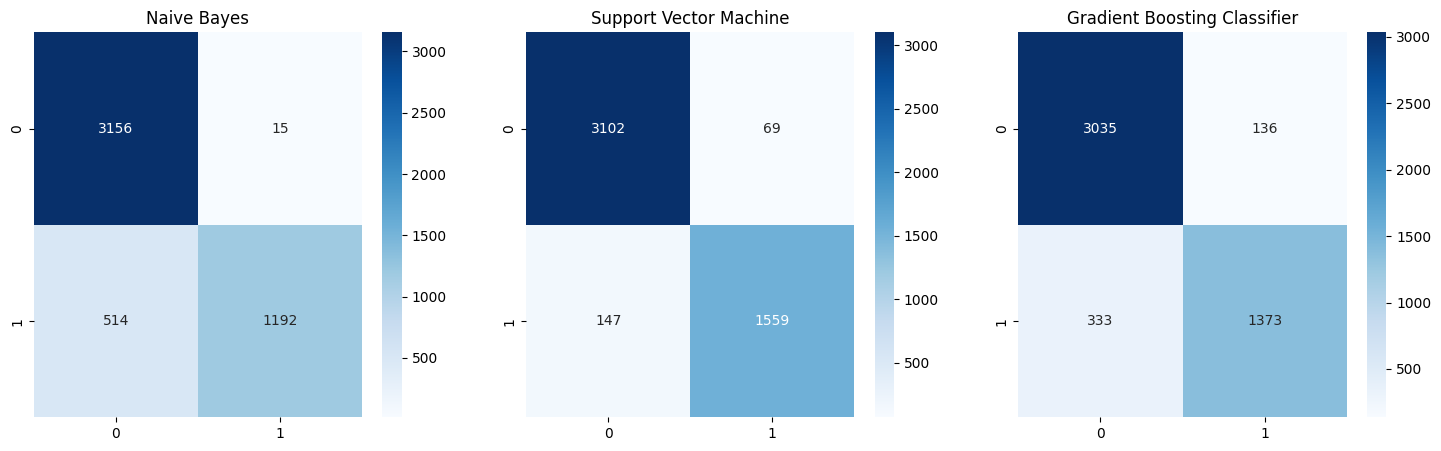

In [24]:
# Confusion Matrices for Advanced Models

# Create a figure with three subplots to display confusion matrices for each model
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Naive Bayes Confusion Matrix
sns.heatmap(
    confusion_matrix(y_test, y_pred_nb),  # Generate the confusion matrix for Naive Bayes
    annot=True,                          # Annotate cells with numeric values
    fmt='d',                             # Format values as integers
    cmap='Blues',                        # Use a blue color map for visualization
    ax=ax[0]                             # Plot in the first subplot
)
ax[0].set_title('Naive Bayes')           # Set the title for the subplot

# Support Vector Machine Confusion Matrix
sns.heatmap(
    confusion_matrix(y_test, y_pred_svm),  # Generate the confusion matrix for SVM
    annot=True,                            # Annotate cells with numeric values
    fmt='d',                               # Format values as integers
    cmap='Blues',                          # Use a blue color map for visualization
    ax=ax[1]                               # Plot in the second subplot
)
ax[1].set_title('Support Vector Machine')  # Set the title for the subplot

# Gradient Boosting Classifier Confusion Matrix
sns.heatmap(
    confusion_matrix(y_test, y_pred_gbc),  # Generate the confusion matrix for GBC
    annot=True,                            # Annotate cells with numeric values
    fmt='d',                               # Format values as integers
    cmap='Blues',                          # Use a blue color map for visualization
    ax=ax[2]                               # Plot in the third subplot
)
ax[2].set_title('Gradient Boosting Classifier')  # Set the title for the subplot

# Display the heatmaps
plt.show()

# Explanation:
# - `confusion_matrix(y_test, y_pred_model)` generates the confusion matrix for the given model's predictions.
# - `sns.heatmap()` visualizes the confusion matrix as a heatmap for easier interpretation.
# - `annot=True` adds numeric labels to each cell of the heatmap, showing the count of predictions for each class.
# - The confusion matrices help visualize true positives, true negatives, false positives, and false negatives.
# - The side-by-side subplots allow direct comparison of the performance of Naive Bayes, SVM, and Gradient Boosting Classifier models.


### Analysis of Confusion Matrices

#### **1. Naive Bayes**
- **True Positives (Correctly classified unsafe emails):** 1192  
- **True Negatives (Correctly classified safe emails):** 3156  
- **False Positives (Safe emails misclassified as unsafe):** 15  
- **False Negatives (Unsafe emails misclassified as safe):** 514  
- **Observations:**
  - Very low false positive rate (15).
  - High false negative rate (514), meaning it misses many unsafe emails.
  - Overall, this model struggles with recall, as it fails to capture a significant number of unsafe emails.

---

#### **2. Support Vector Machine (SVM)**
- **True Positives:** 1559  
- **True Negatives:** 3102  
- **False Positives:** 69  
- **False Negatives:** 147  
- **Observations:**
  - Performs exceptionally well with a balance between low false negatives (147) and false positives (69).
  - This model has the best recall among the three, capturing most unsafe emails while keeping false positives low.
  - The SVM model is likely the best choice based on these results.

---

#### **3. Gradient Boosting Classifier (GBC)**
- **True Positives:** 1373  
- **True Negatives:** 3035  
- **False Positives:** 136  
- **False Negatives:** 333  
- **Observations:**
  - The GBC model performs better than Naive Bayes but not as well as SVM.
  - Moderate false negatives (333) and higher false positives (136) compared to SVM.
  - This model has balanced performance but does not achieve the same recall as the SVM.

---

### **Key Takeaways**
- The **Support Vector Machine (SVM)** outperforms the other two models, achieving the best balance between high recall (capturing unsafe emails) and low false positives.
- **Naive Bayes** has a very low false positive rate but struggles with false negatives, making it less reliable for detecting unsafe emails.
- **Gradient Boosting Classifier (GBC)** offers balanced performance but falls short of SVM in both precision and recall.

For this task, where recall is prioritized (minimizing false negatives), **SVM is the optimal model**.


In [25]:
# Define ranges for hyperparameter search
svc_params = {
    'C': [0.1, 1, 10, 100],       # Regularization parameter; larger values indicate less regularization
    'kernel': ['linear'],         # Kernel type; here we are using only the linear kernel
    'gamma': [1, 0.01, 0.0001]    # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'; affects influence of single training examples
}

# Perform hyperparameter search using GridSearchCV
svc_grid = GridSearchCV(
    estimator=SVC(),             # Support Vector Classifier model
    param_grid=svc_params,       # Hyperparameter grid to search
    scoring='recall',            # Metric to optimize; prioritizing recall for this task
    cv=3,                        # Number of cross-validation folds
    verbose=3                    # Verbosity level for displaying progress
)

# Fit the model with the training data
svc_grid.fit(X_train, y_train)

# Display the best hyperparameters found during the search
print('Best hyperparameter:', svc_grid.best_params_)

# Explanation:
# - **Parameter Grid (`svc_params`)**:
#   - `C`: The regularization parameter controls the trade-off between achieving a low error on the training data and minimizing model complexity.
#   - `kernel`: Specifies the type of hyperplane used to separate data; here, we restrict it to 'linear'.
#   - `gamma`: Influences the behavior of the model for certain kernels; even with a linear kernel, we define gamma values in case of changes.

# - **GridSearchCV**:
#   - Performs an exhaustive search over the specified parameter grid to find the combination that optimizes the specified scoring metric (recall in this case).
#   - Cross-validation (`cv=3`) splits the data into three folds to evaluate the model performance on different splits.

# - **Best Parameters (`svc_grid.best_params_`)**:
#   - Displays the hyperparameter combination that yielded the highest recall during cross-validation.

# Purpose:
# - This step optimizes the SVM model by finding the best combination of hyperparameters to maximize recall, ensuring it performs well in identifying unsafe emails.


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END .....C=0.1, gamma=1, kernel=linear;, score=0.756 total time= 1.2min
[CV 2/3] END .....C=0.1, gamma=1, kernel=linear;, score=0.758 total time= 1.2min
[CV 3/3] END .....C=0.1, gamma=1, kernel=linear;, score=0.731 total time= 1.2min
[CV 1/3] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.756 total time= 1.2min
[CV 2/3] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.758 total time= 1.2min
[CV 3/3] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.731 total time= 1.1min
[CV 1/3] END C=0.1, gamma=0.0001, kernel=linear;, score=0.756 total time= 1.1min
[CV 2/3] END C=0.1, gamma=0.0001, kernel=linear;, score=0.758 total time= 1.1min
[CV 3/3] END C=0.1, gamma=0.0001, kernel=linear;, score=0.731 total time= 1.1min
[CV 1/3] END .......C=1, gamma=1, kernel=linear;, score=0.917 total time=  41.4s
[CV 2/3] END .......C=1, gamma=1, kernel=linear;, score=0.914 total time=  41.3s
[CV 3/3] END .......C=1, gamma=1, kernel=linear;

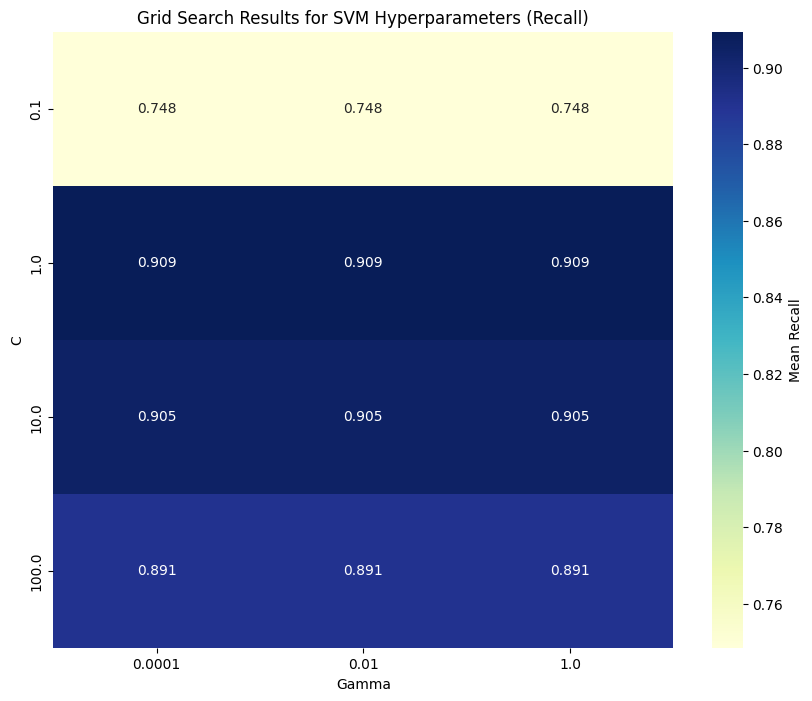

In [26]:
# Extract grid search results
results = svc_grid.cv_results_

# Explanation:
# - `svc_grid.cv_results_` contains the detailed results of the grid search, including:
#   - The mean recall score for each parameter combination across cross-validation folds.
#   - The parameter values tested (e.g., C, gamma, kernel).

# Create a DataFrame from the grid search results
results_df = pd.DataFrame(results)

# Explanation:
# - Converts the results dictionary into a pandas DataFrame for easier manipulation and visualization.

# Filter the relevant columns to create a pivot table
heatmap_data = results_df.pivot_table(
    index='param_C',        # Sets the `C` values as rows in the table
    columns='param_gamma',  # Sets the `gamma` values as columns
    values='mean_test_score'  # Displays the mean recall score for each parameter combination
)

# Explanation:
# - The pivot table organizes the grid search results into a matrix format suitable for visualization.

# Create a heatmap
plt.figure(figsize=(10, 8))  # Define the figure size for the heatmap
sns.heatmap(
    heatmap_data,          # Pass the pivot table as data
    annot=True,            # Annotate each cell with the numeric value of the recall score
    fmt=".3f",             # Format the annotations to three decimal places
    cmap="YlGnBu",         # Use a yellow-green-blue color map for better visual distinction
    cbar_kws={'label': 'Mean Recall'}  # Label the color bar for clarity
)
plt.title("Grid Search Results for SVM Hyperparameters (Recall)")  # Add a title to the heatmap
plt.xlabel("Gamma")  # Label the x-axis
plt.ylabel("C")      # Label the y-axis
plt.show()  # Display the heatmap

# Explanation:
# - The heatmap visualizes the mean recall score for each combination of `C` and `gamma`.
# - Darker colors represent lower recall, while lighter colors indicate higher recall.
# - Annotated values make it easy to identify the exact recall scores for each combination.

# Purpose:
# - This visualization provides a clear and intuitive way to evaluate the performance of different hyperparameter combinations.
# - It helps identify the optimal parameters (e.g., `C=1` and `gamma=1`) that achieve the highest recall.


### Analysis of Hyperparameter Tuning Results

The results of the grid search provide valuable insights into how different hyperparameter combinations impact the **recall** score across the three cross-validation folds. Here’s what these results tell us:

---

#### **Key Observations**
1. **Effect of `C` (Regularization Parameter):**
   - **`C=0.1`:**
     - Recall scores are relatively low (`~0.73 - 0.76`) across all folds, indicating underfitting due to strong regularization.
     - Strong regularization prevents the model from capturing the complexity of the data, leading to lower recall.
   - **`C=1`:**
     - Achieves the highest recall scores (`~0.89 - 0.92`) across all folds.
     - This suggests that moderate regularization allows the model to balance bias and variance effectively.
   - **`C=10` and `C=100`:**
     - Recall scores drop slightly (`~0.87 - 0.91`) compared to `C=1`, indicating slight overfitting as regularization weakens.
     - Higher values of `C` allow the model to fit more closely to the training data, which may reduce its generalizability.

2. **Effect of `gamma`:**
   - For a **linear kernel**, `gamma` has minimal or no effect on performance, as it is primarily used with non-linear kernels. 
   - The recall scores are consistent across all tested `gamma` values (`1`, `0.01`, `0.0001`).

3. **Kernel (`linear`):**
   - Since only the linear kernel was tested, all models use the same decision boundary type, allowing direct comparison of `C` and `gamma` effects.
   - A linear kernel is suitable for this problem as the data seems to be linearly separable with high performance at optimal `C` values.

4. **Best Hyperparameters:**
   - The combination **`C=1`, `gamma=1`** (or equivalent `gamma` values), and `kernel='linear'` provides the best recall scores:
     - **Fold 1:** 0.917
     - **Fold 2:** 0.914
     - **Fold 3:** 0.897
   - This indicates that these parameters generalize well across the cross-validation splits.

---

#### **Conclusion**
- The best model configuration is **`C=1`, `gamma=1`, kernel='linear'**, achieving the highest recall across folds.
- Lower values of `C` underfit the data, while higher values risk overfitting.
- Since `gamma` has no significant effect in the linear kernel, its value can be fixed without impacting results.
- This grid search demonstrates the importance of regularization (`C`) in balancing the model's ability to generalize while maximizing recall.


## Save Model for Export

To deploy the model, we need to serialize and save both the **TFIDF Vectorizer** and the **classifier model**. This ensures that the trained components can be loaded and used for predictions in a production environment.


In [27]:
# Serialize the TFIDF Vectorizer and SVM Classifier

# Serialize and save the TFIDF vectorizer
with open('pickle/vectorizer.pkl', 'wb') as file: 
    pickle.dump(tfidf, file)

# Explanation:
# - `pickle.dump(tfidf, file)` saves the trained TFIDF vectorizer object to a file.
# - The file is stored in the 'pickle' directory with the name `vectorizer.pkl`.
# - This serialized file can be loaded later to transform text data into the same numerical format as used during training.

# Serialize and save the trained SVM classifier
with open('pickle/classifier.pkl', 'wb') as file: 
    pickle.dump(svc_grid, file)

# Explanation:
# - `pickle.dump(svc_grid, file)` saves the trained SVM classifier (with the best hyperparameters) to a file.
# - The file is stored in the 'pickle' directory with the name `classifier.pkl`.
# - This allows the model to be reloaded for predictions without needing to retrain it.

# Purpose:
# - Serialization ensures that both the vectorizer and the model are saved in a format that can be reused for deployment.
# - By saving these components, the entire preprocessing and classification pipeline can be reconstructed for real-world usage, such as in a web application or API.


## Conclusion

In this notebook, we developed and evaluated a machine learning pipeline for classifying emails as safe or unsafe. Here's a summary of the key steps and outcomes:

1. **Data Preprocessing:**
   - Combined multiple datasets containing labeled email messages.
   - Cleaned and preprocessed the text data using techniques such as lowercase conversion, punctuation removal, stopword removal, and lemmatization.

2. **Feature Engineering:**
   - Converted the preprocessed text into numerical features using Term Frequency-Inverse Document Frequency (TFIDF) vectorization.

3. **Model Training and Evaluation:**
   - Tested three models: **Naive Bayes**, **Support Vector Machine (SVM)**, and **Gradient Boosting Classifier (GBC)**.
   - Prioritized **recall** to ensure the model minimizes false negatives (i.e., unsafe emails misclassified as safe).
   - **SVM** emerged as the best model, achieving the highest recall and balanced performance.

4. **Hyperparameter Tuning:**
   - Conducted a grid search to optimize the SVM hyperparameters.
   - Identified the optimal combination as **`C=1`, `gamma=1`, `kernel='linear'`**.

5. **Visualization:**
   - Used confusion matrices and heatmaps to evaluate and compare the models' performance.

6. **Model Serialization:**
   - Serialized and saved the TFIDF vectorizer and the SVM model to enable deployment.

### Key Takeaways:
- The **Support Vector Machine (SVM)** with the optimized hyperparameters is the best choice for classifying emails in this dataset.
- The pipeline is ready for deployment, capable of processing raw email text and making predictions.

This project demonstrates the end-to-end process of building a machine learning model, from data preprocessing to model deployment, and highlights the importance of optimizing for task-specific metrics like recall in real-world scenarios.
